In [2]:
import fastai
fastai.__version__

'2.7.11'

In [4]:
from fastai.vision.all import *

In [5]:
path = Path("../input/indoor-scenes-cvpr-2019/indoorCVPR_09/")
Path.BASE_PATH = path
path.ls()

(#1) [Path('Images')]

# Dataset and Dataloader

In [6]:
def custom_splitter(train_name, valid_name, train_pct):
    def fn(name_list):
        train_idx, valid_idx = RandomSplitter()(name_list)
        np.random.shuffle(train_idx)
        train_len = int(len(train_idx) * train_pct)
        valid_len = int(len(valid_idx)* train_pct)
        return train_idx[0:train_len], valid_idx[0:valid_len]
    return fn

In [7]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y = parent_label,
                  splitter=custom_splitter(train_name="train_name", valid_name="valid_name", train_pct=0.9),
                  item_tfms = Resize(224))

In [8]:
ds = dblock.datasets(path)
len(ds), len(ds.train), len(ds.valid)

(15620, 11246, 2811)

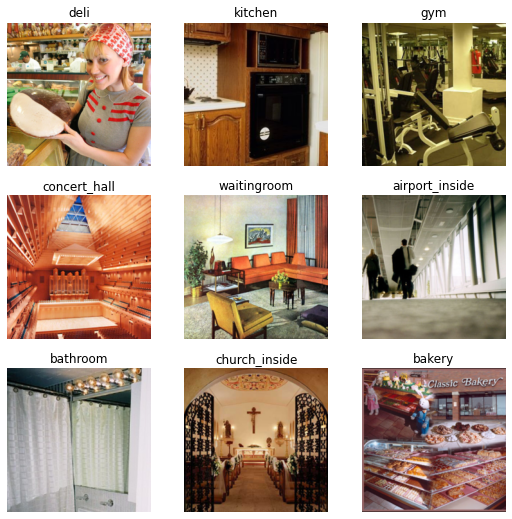

In [9]:
dls = dblock.dataloaders(path)
dls.show_batch()

# Model

In [11]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

In [12]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.718935,1.563635,0.581644,02:26


epoch,train_loss,valid_loss,accuracy,time
0,1.599841,1.177299,0.670224,02:14
1,1.164568,1.076070,0.698684,02:12
2,0.698656,0.999077,0.718961,02:14
3,0.397874,0.961607,0.738527,02:15
4,0.273744,0.956356,0.738171,02:20


In [13]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.620312,1.439930,0.600854,02:17


epoch,train_loss,valid_loss,accuracy,time
0,1.430144,1.070570,0.700462,02:28
1,1.031790,0.944133,0.737460,02:19
2,0.597618,0.885890,0.758805,02:19
3,0.296397,0.846754,0.773390,02:18
4,0.163452,0.835853,0.772323,02:20


# Data Augmentation

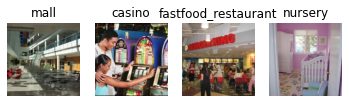

In [14]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
dls_test = dblock.new(item_tfms=Resize(360), 
                      batch_tfms=batch_tfms)
dls = dls_test.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, figsize=(6,7))

In [15]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.660970,1.427691,0.602988,02:42


epoch,train_loss,valid_loss,accuracy,time
0,1.524970,1.090680,0.690146,02:41
1,1.179454,0.990520,0.717538,02:44
2,0.826467,0.888877,0.747421,02:51
3,0.497498,0.839898,0.769477,02:48
4,0.372947,0.820221,0.775880,02:42


**model interpretation**

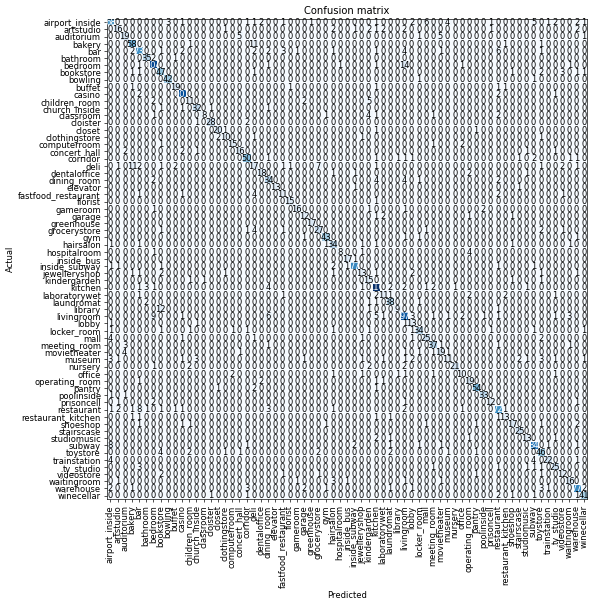

In [16]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [23]:
interp.most_confused(5)

[('bedroom', 'livingroom', 14),
 ('library', 'bookstore', 12),
 ('bakery', 'deli', 11),
 ('deli', 'bakery', 11),
 ('livingroom', 'bedroom', 9),
 ('restaurant', 'bar', 8),
 ('subway', 'airport_inside', 8),
 ('deli', 'grocerystore', 7),
 ('airport_inside', 'mall', 6),
 ('bar', 'restaurant', 6),
 ('livingroom', 'dining_room', 6),
 ('airport_inside', 'subway', 5),
 ('auditorium', 'concert_hall', 5),
 ('auditorium', 'movietheater', 5),
 ('children_room', 'kindergarden', 5),
 ('livingroom', 'kitchen', 5)]

**learning rate finder**

In [18]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.202948,1.331157,0.638563,02:36
1,1.387143,1.030694,0.700818,02:38
2,1.034781,0.952146,0.715048,02:37


SuggestedLRs(valley=0.0003311311302240938)

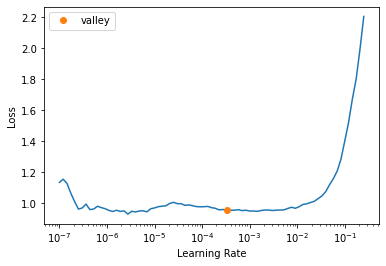

In [19]:
learn.lr_find()

In [20]:
learn.unfreeze()

SuggestedLRs(valley=9.120108734350652e-05)

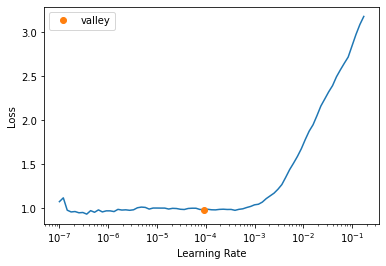

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(5, lr_max=slice(5e-6, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.968300,0.921573,0.733903,02:40
1,0.861782,0.887504,0.751690,02:43
2,0.660052,0.831236,0.759872,02:48
3,0.487861,0.809915,0.765564,02:44
4,0.409607,0.802037,0.765564,02:37


**Full dataset**

In [24]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y = parent_label,
                  splitter=custom_splitter(train_name="train_name", valid_name="valid_name", train_pct=0.9),
                  item_tfms = Resize(360),
                  batch_tfms=batch_tfms)

In [25]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, lr_max=3e-3)
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(5e-6, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.173460,1.253670,0.645678,02:31
1,1.399490,1.019231,0.700818,02:33
2,1.051917,0.926760,0.731768,02:33


epoch,train_loss,valid_loss,accuracy,time
0,0.964867,0.889703,0.741729,02:43
1,0.864911,0.855626,0.762006,02:54
2,0.639690,0.815316,0.768766,03:00
3,0.485153,0.790438,0.769121,02:41
4,0.412401,0.790169,0.768410,02:38


In [26]:
torch.save(learn.model.state_dict(), './indoor_scene.pth')